In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def f_true(x):
    return 0.03 * x ** 4 - 0.4 * x ** 2 + 0.7 * np.sin(2.2 * x)

def make_poly_features(x, degree):
    x = np.asarray(x).reshape(-1, 1)
    X = np.hstack([x ** i for i in range(degree + 1)])
    return X

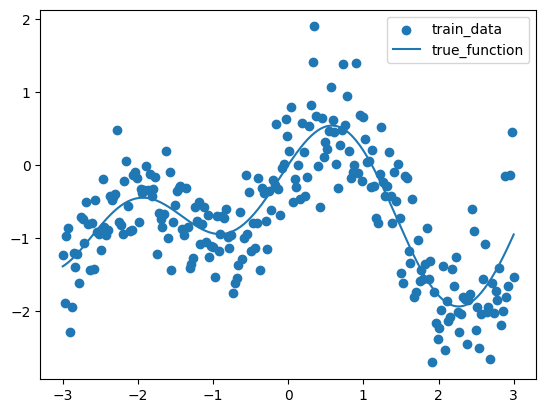

In [22]:
rng = np.random.default_rng(42)

N = 250
x = np.linspace(-3, 3, N)

sigma = 0.5
y = f_true(x) + rng.normal(0, sigma, size=x.shape)

degree = 15
X = make_poly_features(x, degree)

plt.scatter(x, y, label='train_data')
plt.plot(x, f_true(x), label='true_function')
plt.legend()
plt.show()

In [5]:
lamb = 1.0
alpha = 1.0 / (sigma ** 2)

M = X.shape[1]
posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)

In [27]:
posterior_cov = np.linalg.inv(posterior_cov_inv)
mean = alpha * posterior_cov @ (X.T @ y)

# print(posterior_cov.shape)

In [7]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

mean_pred = X_new @ mean
var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
std_pred = np.sqrt(var_pred)

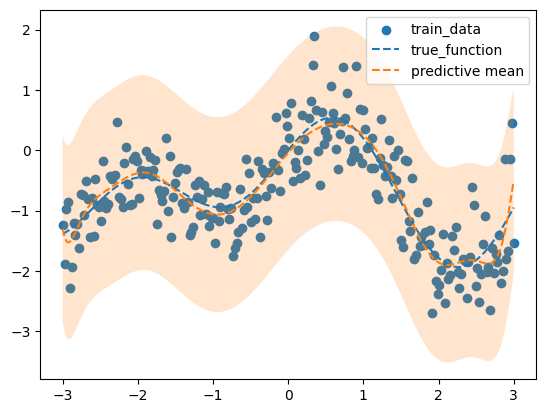

In [8]:
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(x_new, mean_pred, linestyle='--', label='predictive mean')

plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, alpha=0.2)

plt.legend()
plt.show()

In [46]:
def log_evidence(lamb, X, y, alpha):
    '''
    Тут надо написать расчет log-evidence, через формулу, которая была в лекции +
    Далее взять какой-то набор лямбд (например np.logspace(-6, 3, 160)) и оценить для каждой эту функцию
    Получится лучшая лябмда +
    Вывести график log-evidence vs lambda + графики, чтобы визуально сравнить предсказания базовой модели и модели с лучшей лямбдой
    '''
    n, m = X.shape

    eps = 10**(-10)

    post = lamb * np.eye(m) + alpha * (X.T @ X) #m x m матрица гёссе, обратная ков. м. (по сути дисперсия)
    sign, logdet = np.linalg.slogdet(post)
    if sign <= 0:
        post += np.eye(m) * eps + alpha * (X.T @ X)
        sign, logdet = np.linalg.slogdet(post)

    post_inv = np.linalg.inv(post)
    mn = alpha * post_inv @ (X.T @ y) # среднее
    #              |      нормировка гауссиана          |штраф за сложность| регуляризация + ошибка|
    # logp(y∣X,α,λ)=m/2 *logλ + n/2 * ​logα− n/2 * log(2π) − 1/2​log∣A∣       −  1/2​(α∥y−XmN​∥2+λ∥mN​∥2)
    res = y - X @ mn
    res_norm2 = float(res.T @ res) # насколько хорошо модель описывает данные
    mn_norm2 = float(mn.T @ mn) #штраф за сложность модели

    norm_gauss = 0.5 * m * np.log(lamb) + 0.5 * n * np.log(alpha) - 0.5 * n * np.log(2 * np.pi)
    complex_penalty = -0.5 * logdet 
    l2_res_penalty = -0.5 * (alpha * res_norm2 + lamb * mn_norm2) # 
    
    logEv = norm_gauss + complex_penalty + l2_res_penalty

    return logEv, mn, post_inv
    



In [47]:
log_evidence(lamb, X, y, alpha)

(np.float64(-300.12914213535214),
 array([-6.06051775e-02,  1.13343361e-01, -5.82277743e-02,  5.19812223e-02,
        -5.83325115e-02, -3.68584348e-04, -4.03638775e-02, -3.99019206e-02,
         1.49364398e-02,  8.01234655e-03, -7.00351525e-04,  4.65124903e-04,
        -1.66902302e-04, -1.96180621e-04,  1.37944847e-05,  1.10765574e-05]),
 array([[ 7.31231597e-04, -4.12493046e-16, -1.23284025e-04,
         -2.31334011e-15, -9.07720756e-05, -3.43560658e-15,
         -4.00748168e-05,  7.07121884e-15,  3.74485929e-05,
         -3.51677630e-15, -8.47563046e-06,  7.49351747e-16,
          7.89113165e-07, -7.29639638e-17, -2.66842122e-08,
          2.66656598e-18],
        [-4.12493046e-16,  8.46731187e-04, -2.83808598e-15,
         -1.34755546e-04, -7.21188351e-15, -1.14608115e-04,
          1.72911386e-14, -4.85977744e-05, -9.92606503e-15,
          4.84027926e-05,  2.37283727e-15, -1.14723238e-05,
         -2.53501530e-16,  1.11860654e-06,  9.99446918e-18,
         -3.96354699e-08],
      

In [48]:
lambdas = np.logspace(-6, 3, 160)
logEvs = []
for lamb in lambdas:
    logEv, _, _ = log_evidence(lamb, X, y, alpha)
    logEvs.append(logEv)


logEvs = np.array(logEvs)

best_idx = np.argmax(logEvs)
best_lambda = lambdas[best_idx]
best_logEv = logEvs[best_idx]

logEv

np.float64(-300.12914213535214)

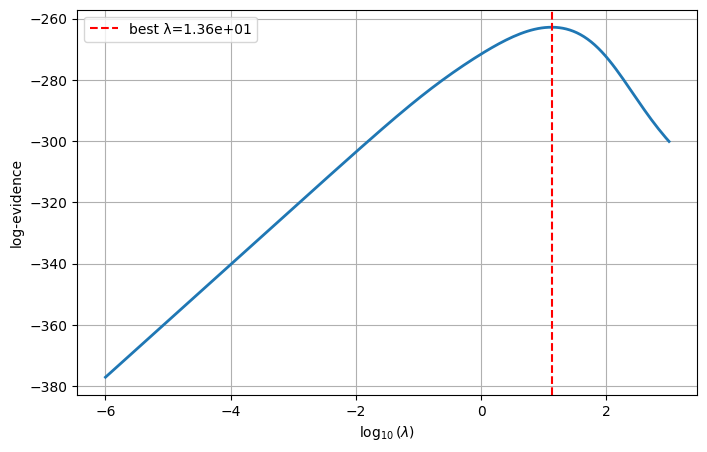

In [51]:
plt.figure(figsize=(8, 5))
plt.plot(np.log10(lambdas), logEvs, lw=2)
plt.axvline(np.log10(best_lambda), color='r', ls='--', label=f'best λ={best_lambda:.2e}')
plt.xlabel(r'$\log_{10}(\lambda)$')
plt.ylabel('log-evidence')
plt.legend()
plt.grid(True)
plt.show()

(200, 16) (16,)


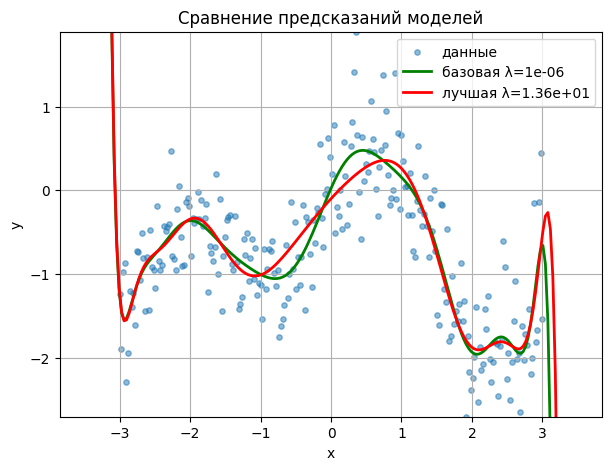

In [64]:
lambda_base = 1e-6
_, mn_base, _ = log_evidence(lambda_base, X, y, alpha)
_, mn_best, _ = log_evidence(best_lambda, X, y, alpha)


m = 16
x_test = np.linspace(-3.5, 3.5, 200)
X_test = np.vstack([x_test**i for i in range(m)]).T
print(X_test.shape, mn_base.shape)

y_true = f_true(x_test)
y_pred_base = X_test @ mn_base
y_pred_best = X_test @ mn_best

# ---------- График 2: сравнение предсказаний ----------
plt.figure(figsize=(7, 5))
plt.scatter(x, y, s=15, alpha=0.5, label='данные')
# plt.plot(x_test, y_true, 'k--', lw=2, label='истинная функция')
plt.plot(x_test, y_pred_base, 'g', lw=2, label=f'базовая λ={lambda_base}')
plt.plot(x_test, y_pred_best, 'r', lw=2, label=f'лучшая λ={best_lambda:.2e}')
plt.title('Сравнение предсказаний моделей')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.ylim(y.min(), y.max()) #!!!!!!

plt.show()


